In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [2]:
# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

In [3]:
# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

In [4]:
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

In [5]:
# reset index to bring Date into the columns for the melt function
data = data.reset_index()

In [6]:
# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

In [7]:
# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

In [8]:
# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-05-18   AAPL  174.125275  175.050003  175.240005  172.580002   
1         2023-05-18   GOOG  123.519997  123.519997  123.900002  121.489998   
2         2023-05-18   MSFT  316.047638  318.519989  319.040009  313.720001   
3         2023-05-18   NFLX  371.290009  371.290009  375.869995  346.369995   
4         2023-05-18   TSLA  176.889999  176.889999  177.059998  172.449997   

Attribute        Open       Volume  
0          173.000000   65496700.0  
1          121.559998   27014500.0  
2          314.529999   27276000.0  
3          347.250000   20925200.0  
4          174.220001  109520300.0  


In [9]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-05-18   AAPL  174.125275  175.050003  175.240005  172.580002  173.000000   
2023-05-18   GOOG  123.519997  123.519997  123.900002  121.489998  121.559998   
2023-05-18   MSFT  316.047638  318.519989  319.040009  313.720001  314.529999   
2023-05-18   NFLX  371.290009  371.290009  375.869995  346.369995  347.250000   
2023-05-18   TSLA  176.889999  176.889999  177.059998  172.449997  174.220001   

Attribute        Volume  
Date                     
2023-05-18   65496700.0  
2023-05-18   27014500.0  
2023-05-18   27276000.0  
2023-05-18   20925200.0  
2023-05-18  109520300.0  


In [ ]:
!pip install seaborn

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

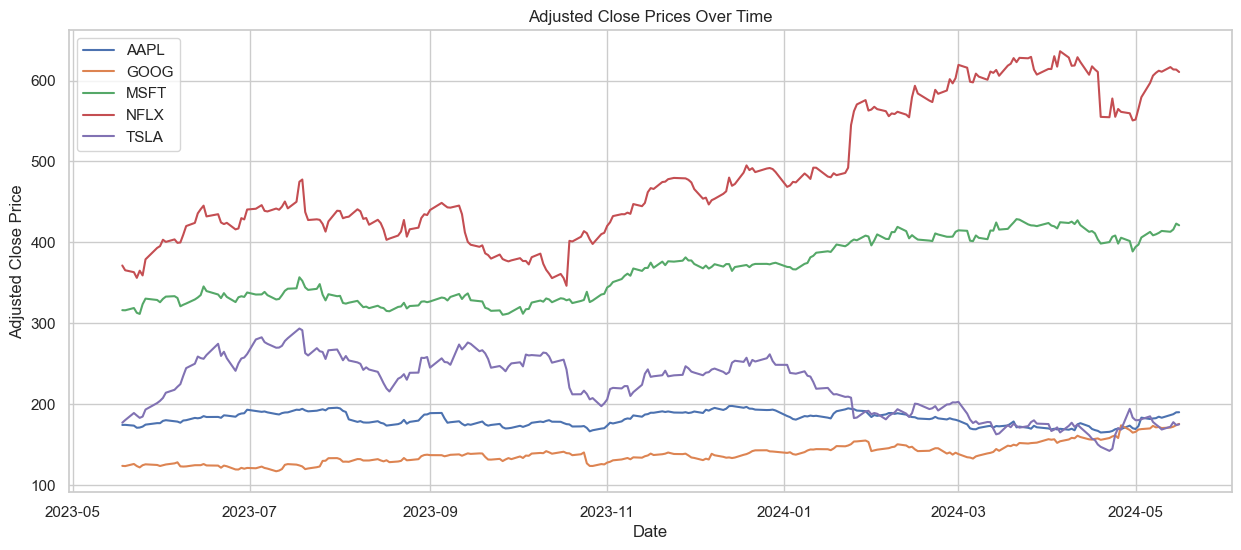

In [13]:
# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

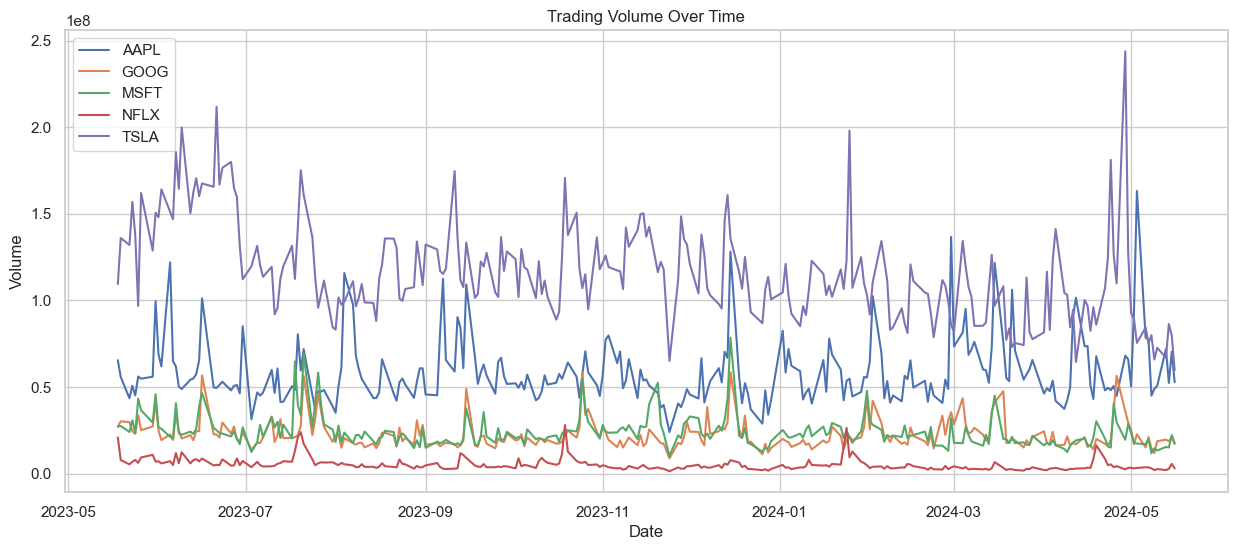

In [16]:
# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [17]:
from scipy.stats import zscore

In [18]:
def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

In [19]:
for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-04-26   GOOG  173.690002  173.690002  176.419998  171.399994  175.990005   
2024-04-29   GOOG  167.899994  167.899994  171.380005  167.059998  170.770004   
2024-04-30   GOOG  164.639999  164.639999  169.869995  164.500000  167.380005   
2024-05-01   GOOG  165.570007  165.570007  168.809998  164.899994  166.179993   
2024-05-02   GOOG  168.460007  168.460007  168.529999  165.690002  166.669998   

Attribute       Volume   Z-score  
Date                              
2024-04-26  56500800.0  2.727378  
2024-04-29  35914600.0  2.277237  
2024-04-30  29420800.0  2.023791  
2024-05-01  25223200.0  2.096094  
2024-05-02  17041100.0  2.320775  


In [20]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-05-31   AAPL  176.313644  177.250000  179.350006  176.759995  177.330002   
2023-06-05   AAPL  178.631332  179.580002  184.949997  178.039993  182.630005   
2023-06-16   AAPL  183.943115  184.919998  186.990005  184.270004  186.729996   
2023-08-04   AAPL  181.028610  181.990005  187.380005  181.919998  185.520004   
2023-08-07   AAPL  177.905212  178.850006  183.130005  177.350006  182.130005   

Attribute        Volume   Z-score  
Date                               
2023-05-31   99625300.0  2.204216  
2023-06-05  121946500.0  3.402373  
2023-06-16  101235600.0  2.290653  
2023-08-04  115799700.0  3.072425  
2023-08-07   97576100.0  2.094219  


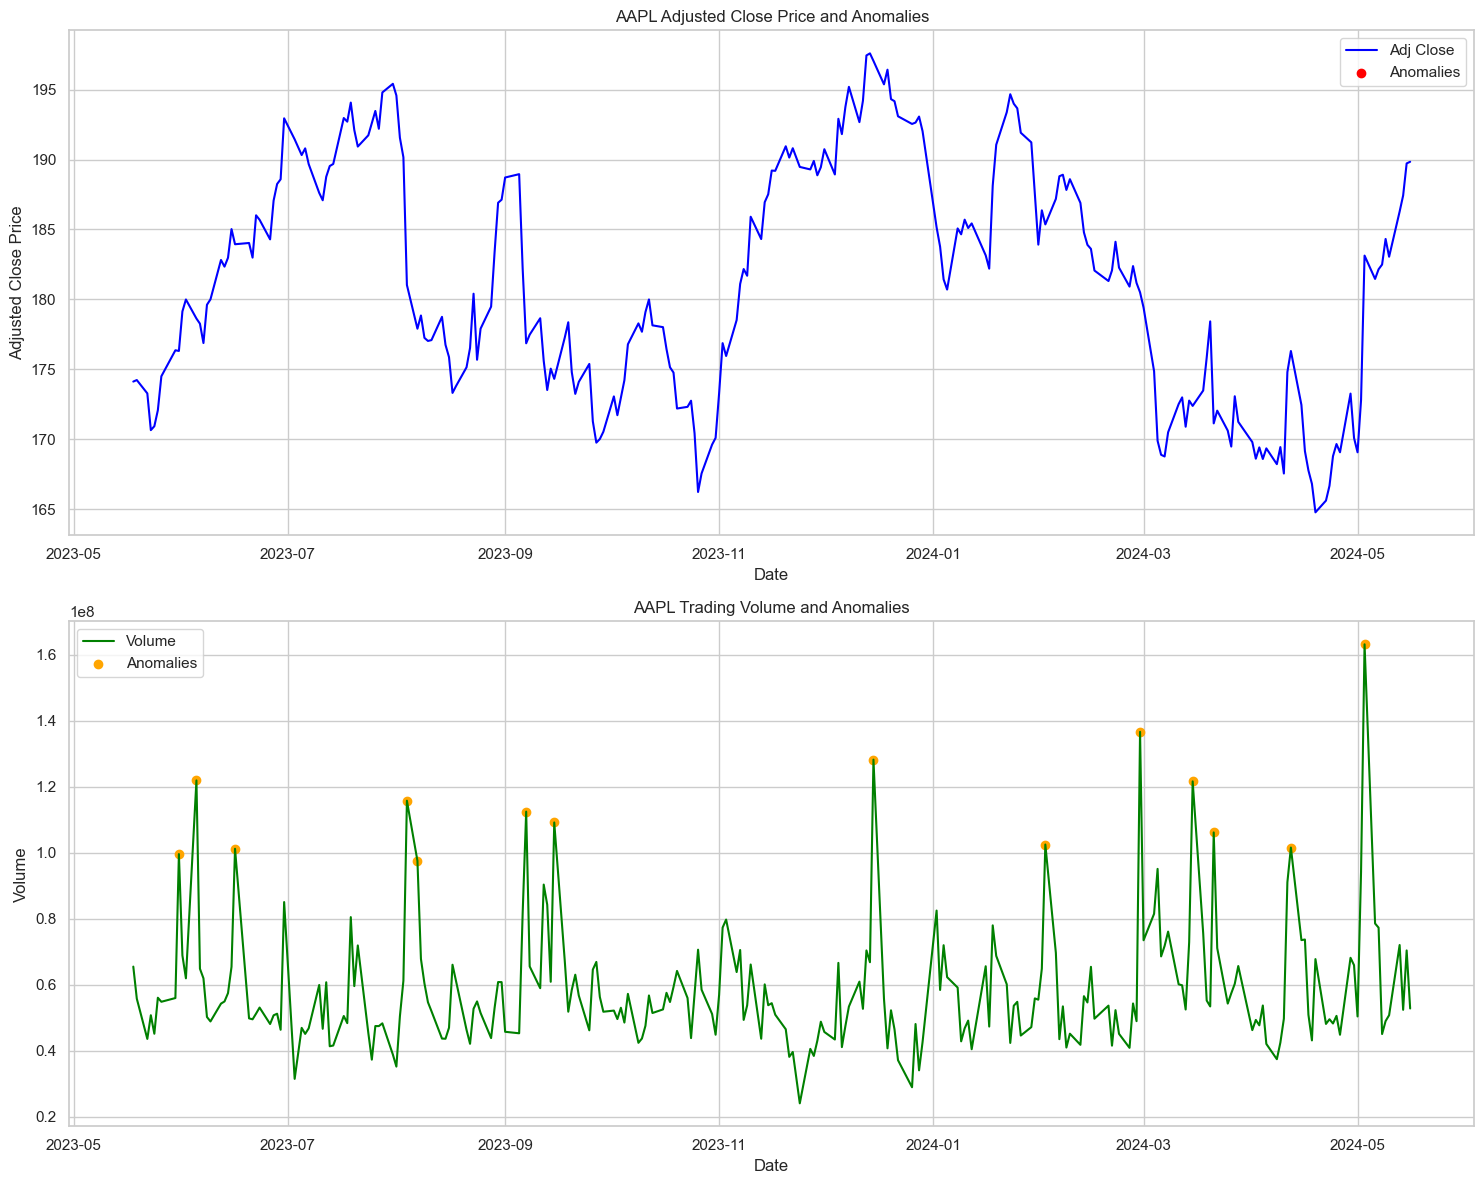

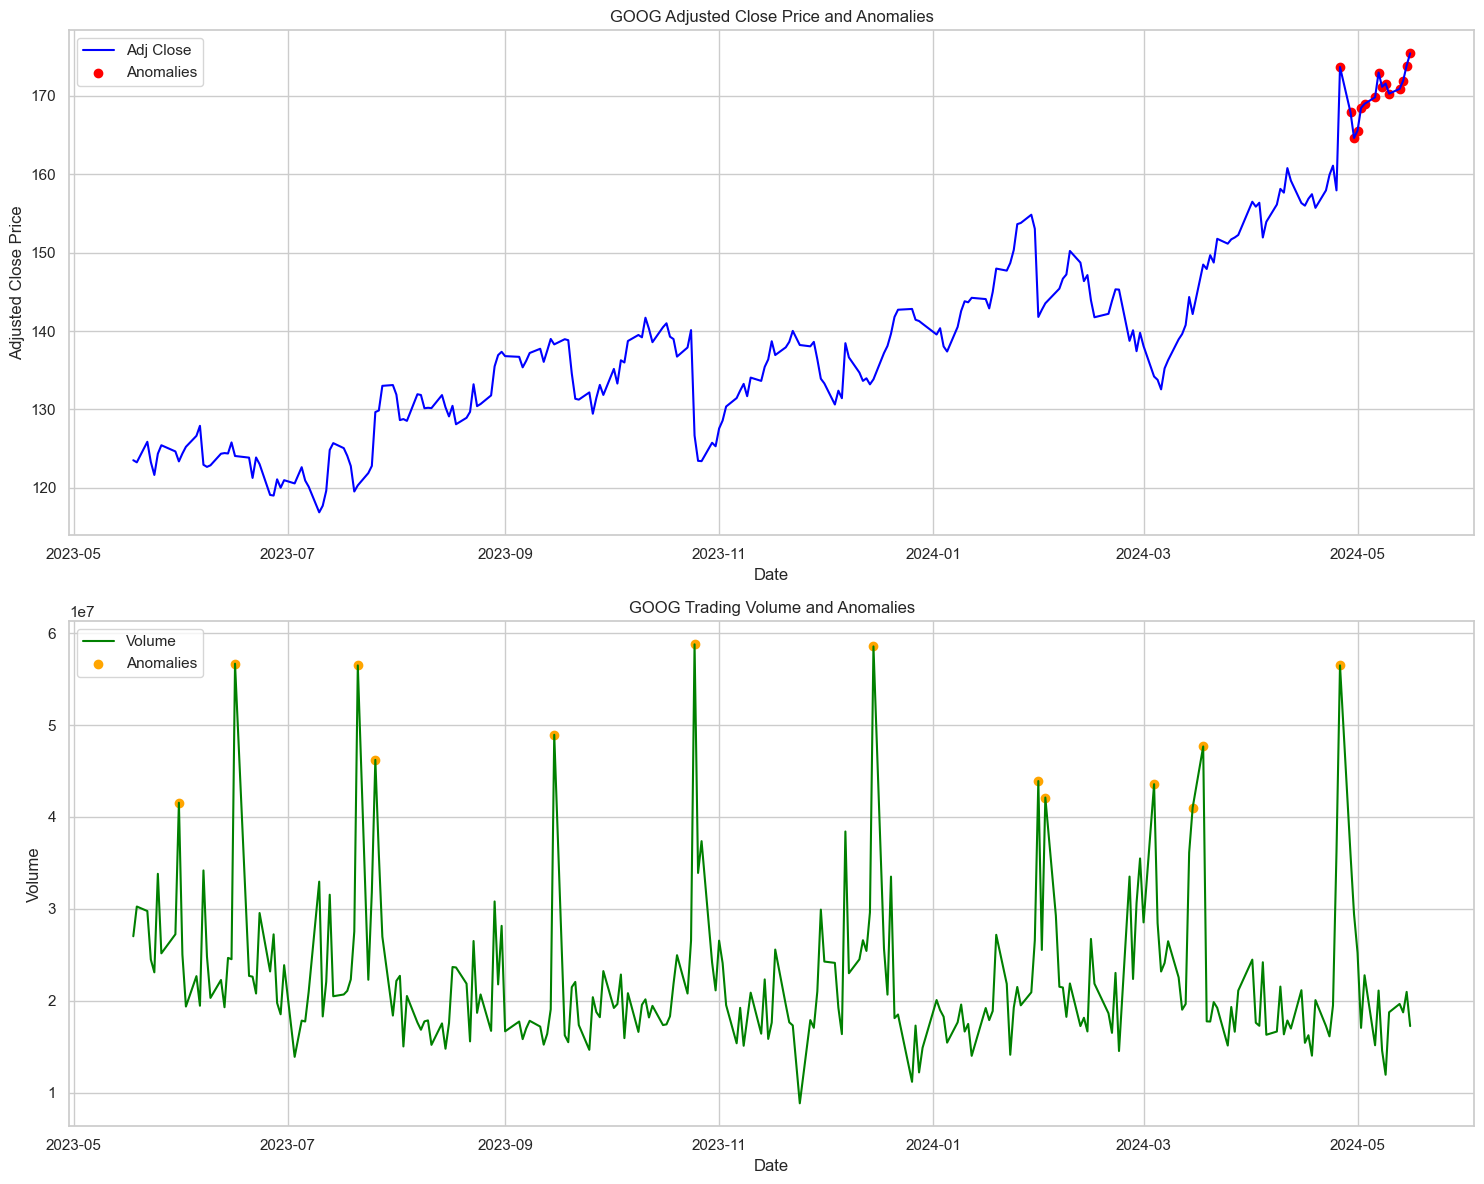

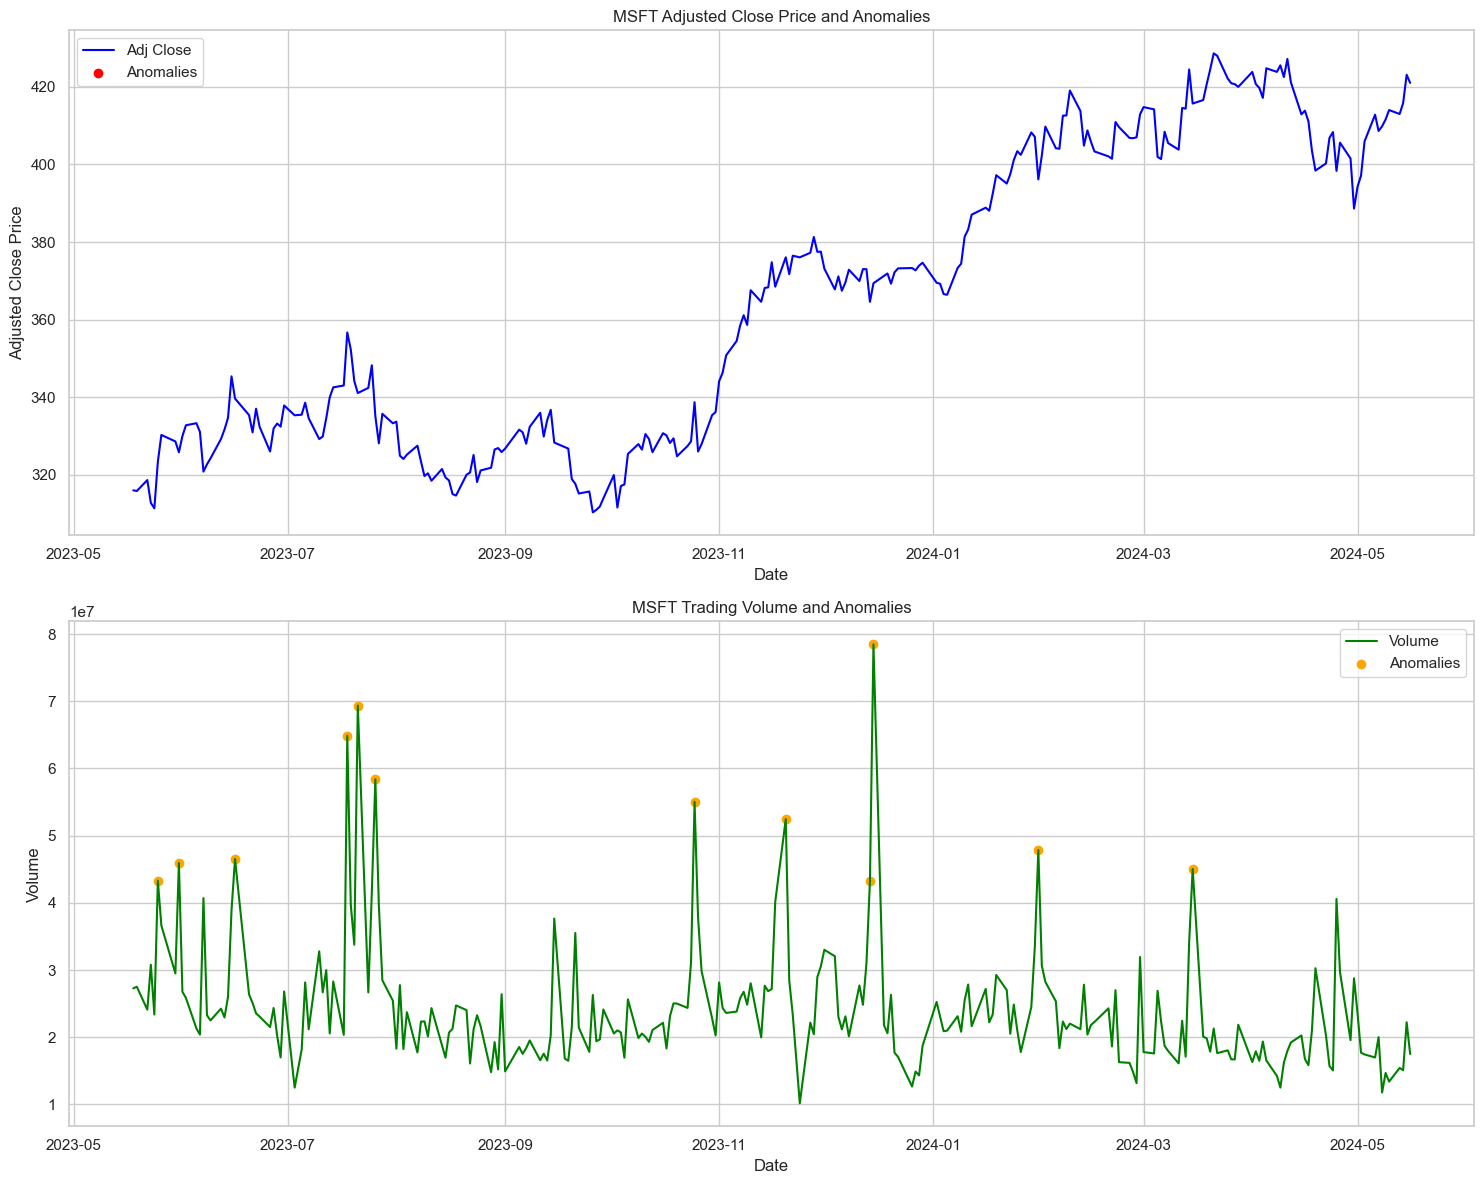

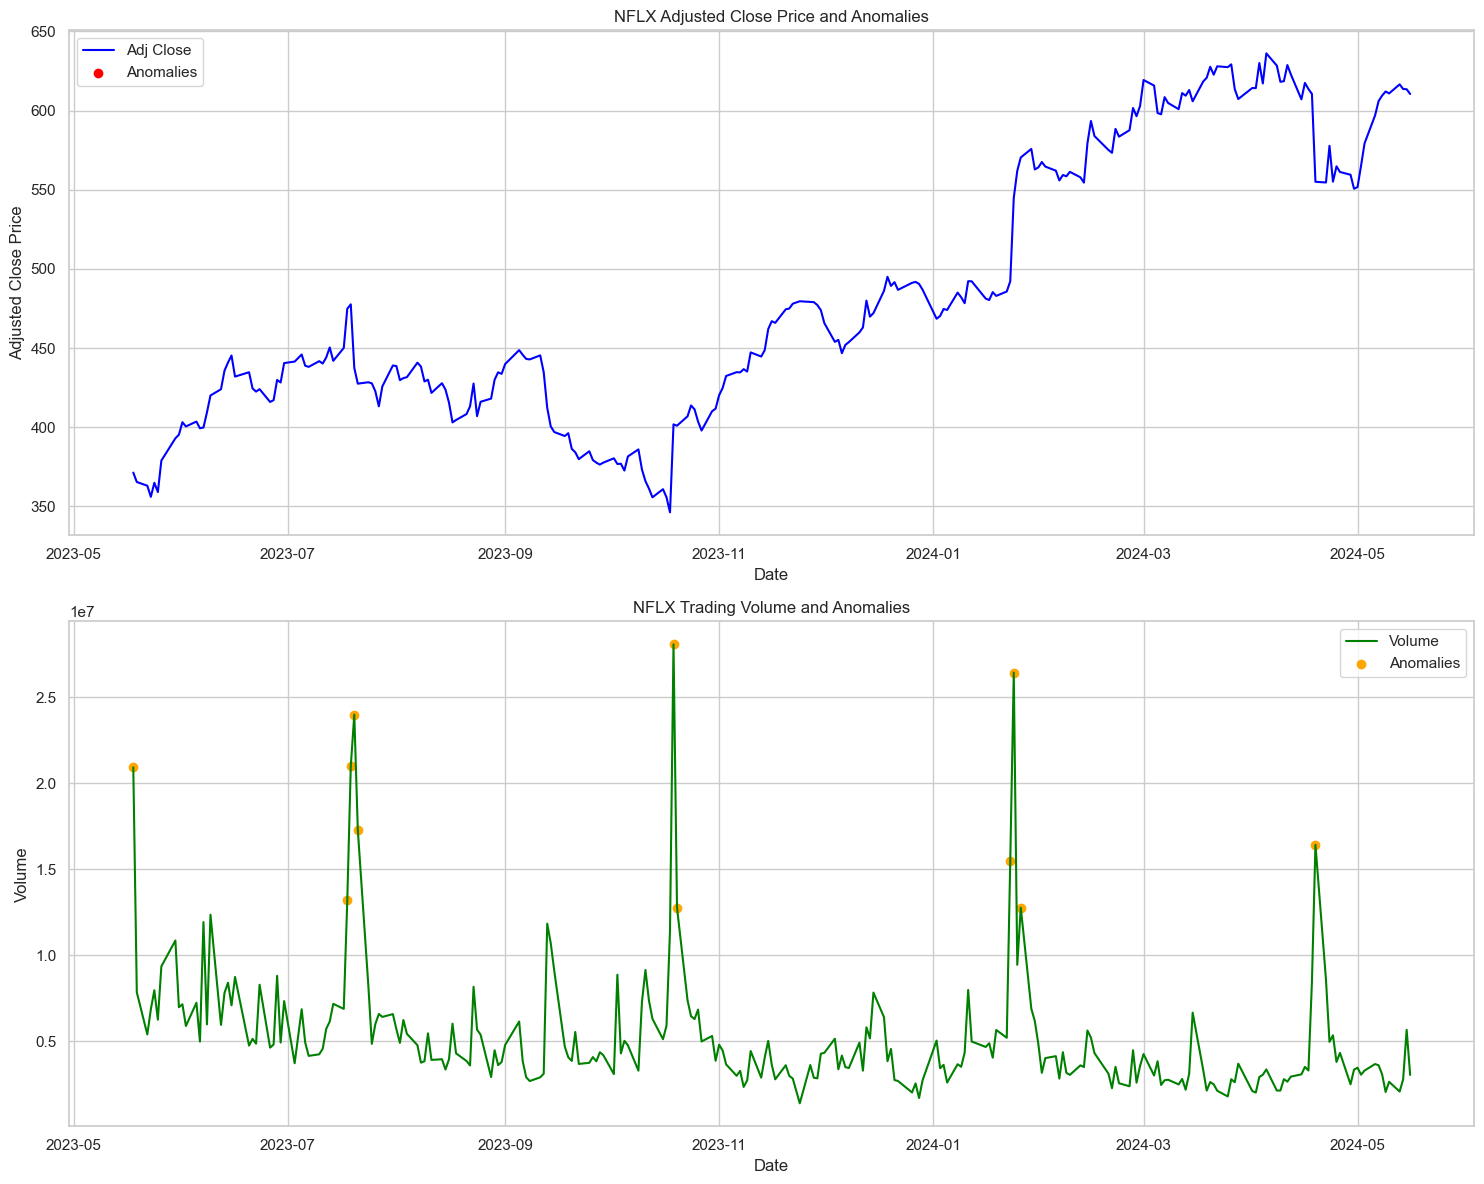

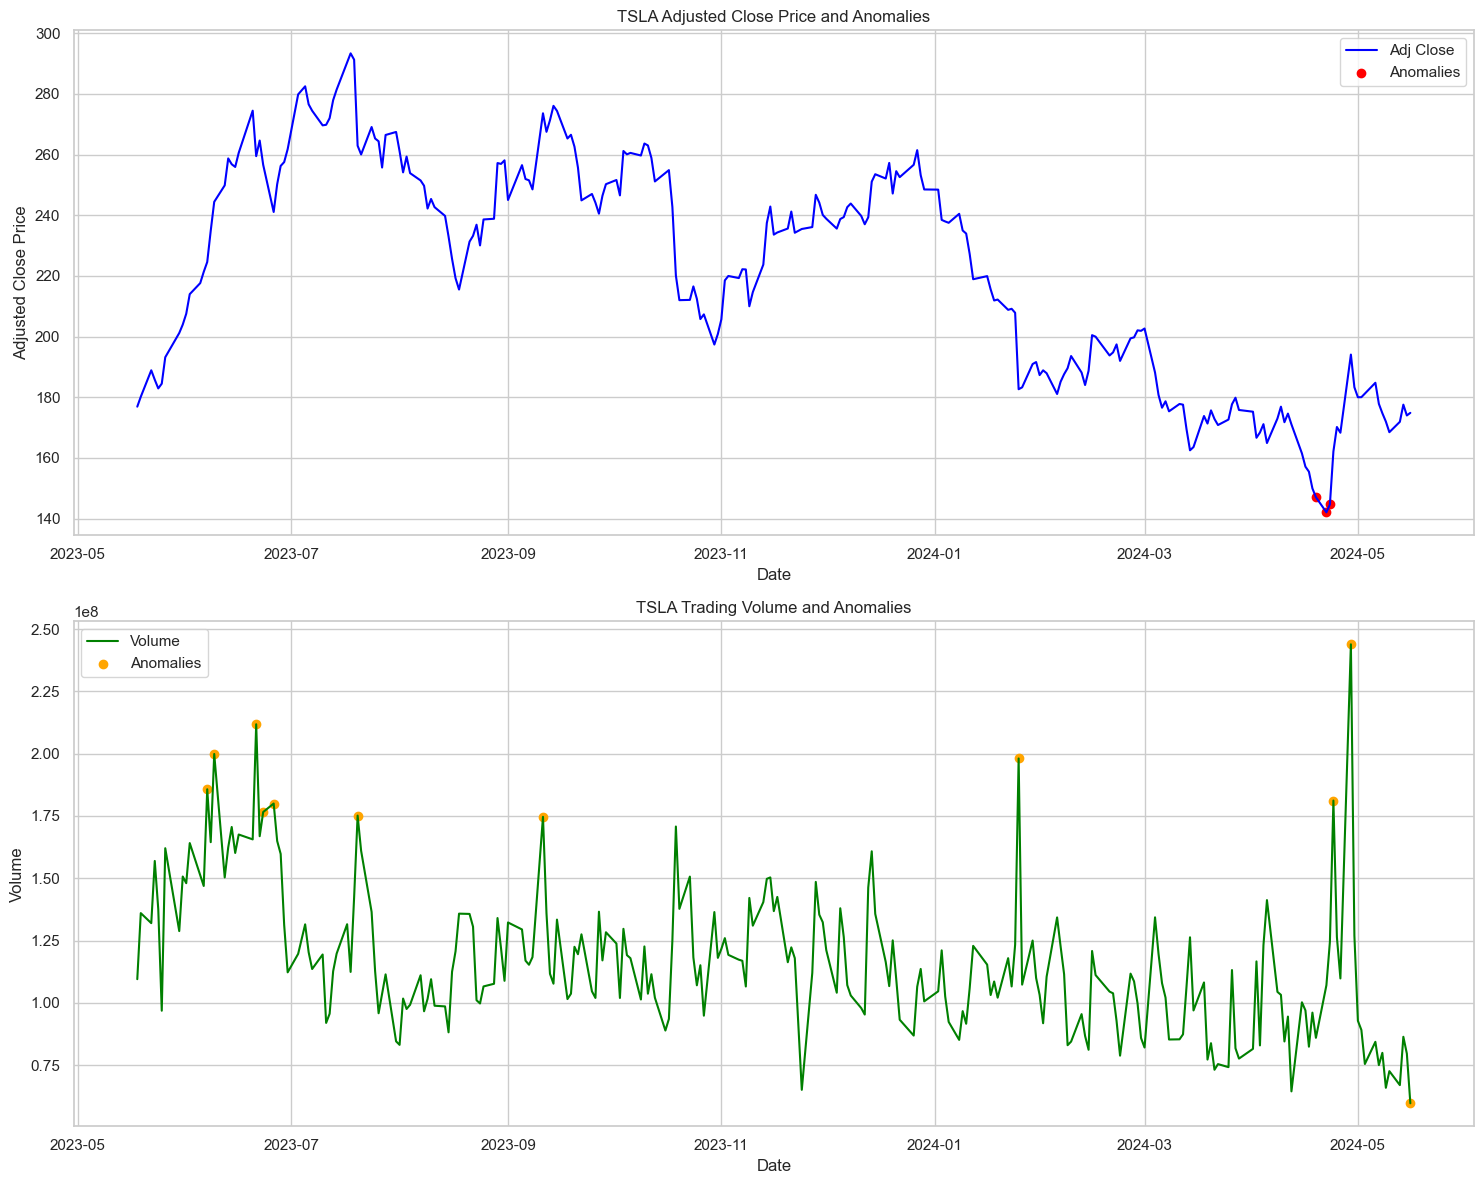

In [26]:
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()
    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    # plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [27]:
# consolidate anomalies for adjusted close prices and volumes
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

In [28]:
# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker', fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker', fill_value=0, aggfunc='sum')

In [29]:
# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

In [30]:
# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

In [31]:
# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

In [32]:
print(correlation_matrix)

                         Adj Close Anomaly           Volume Anomaly            \
Ticker                                GOOG      TSLA           AAPL      GOOG   
                  Ticker                                                        
Adj Close Anomaly GOOG            1.000000 -1.000000       0.250000  0.250000   
                  TSLA           -1.000000  1.000000      -0.250000 -0.250000   
Volume Anomaly    AAPL            0.250000 -0.250000       1.000000  0.199313   
                  GOOG            0.250000 -0.250000       0.199313  1.000000   
                  MSFT                 NaN       NaN       0.019920  0.498239   
                  NFLX           -1.000000  1.000000      -0.394405 -0.258839   
                  TSLA            0.408248 -0.408248      -0.394405 -0.373878   

                                                        
Ticker                        MSFT      NFLX      TSLA  
                  Ticker                                
Adj Close Anomaly 

In [33]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

In [34]:
# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

In [35]:
# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

In [36]:
print(risk_rating)

Ticker
AAPL    NaN
GOOG    1.0
MSFT    NaN
NFLX    NaN
TSLA    0.0
Name: Z-score, dtype: float64
